In [ ]:
#| default_exp sampler.tree

This data structure is based on the Python package `anytree` (https://github.com/c0fec0de/anytree)  which has been extended by the classes `Constant`, `Variable` and `CountTree`.

In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| export

from anytree import RenderTree, PreOrderIter, Node, NodeMixin
import qsample.math as math
import numpy as np
import itertools as it
import pydot

from fastcore.test import *

In [ ]:
#| export

def draw_tree(tree, verbose=False, path=None):
    """Generate and return PNG image of `tree`

    To display the image in command line call .show() on the returned
    PIL image object.

    Parameters
    ----------
    path : str or None
        File path to save png image to, if None only display image

    Returns
    -------
    PNG image
        Image of `CountTree`
    """

    def gen_node(node):
        """Generate pydot.Node object from `Constant` of `Variable`
        
        Parameters
        ----------
        node : Constant or Variable
            `CountNode` to generate pydot.Node object from

        Returns
        -------
        pydot.Node
            Graphical representation of node
        """
        if isinstance(node, Variable):
            color = "#ff0000" if node in tree.marked else "black"
            return pydot.Node(hex(id(node)), label=f"{node.name} : {node.count}", style="filled", color=color, fillcolor="white", shape="ellipse")
        if isinstance(node, Delta):
            return pydot.Node(hex(id(node)), label=f"δ", style="filled", fillcolor="#efefef", shape="box")
        if isinstance(node, Constant):
            return pydot.Node(hex(id(node)), label=f"{node.name} : {node.count}", style="filled", fillcolor="white", shape="box")

    def edgeattrfunc(node, child):
        """
        Parameters
        ----------
        node : Constant or Variable
            Parent node of a (node, child) pair
        child : 
            Child node of a (node, child) pair

        Returns
        -------
        dict
            Specification of the thickness of the edge between `node` and `child`
        """
        weight = 0 if tree.root.count == 0 or isinstance(child, Delta) else 10.0 * child.count / tree.root.count 
        weight = min(weight, 5.0) if weight > 5.0 else max(weight, 0.2)
        return {"penwidth": str(weight)}

    G = pydot.Dot(graph_type="digraph")

    for node in PreOrderIter(tree.root):
        if not verbose and (isinstance(node, Delta) or node.count == 0): 
            continue
        nodeA = gen_node(node)
        G.add_node(nodeA)
        for child in node.children:
            if not verbose and (isinstance(child, Delta) or child.count == 0): 
                continue
            nodeB = gen_node(child)
            edge = pydot.Edge(nodeA,nodeB,**edgeattrfunc(node,child))
            G.add_edge(edge)

    if path is not None:
        G.write_png(path)

    from PIL import Image
    from io import BytesIO
    return Image.open(BytesIO(G.create_png()))

In [ ]:
#| export
class Constant(Node):
    """Class to represent a tree node of a `Tree`.
    
    A node in a tree is a uniquely identifiable object containing references
    to at most one parent and possibly many children. The root node has no 
    parent and leaf nodes have not children.
    
    The `CountNode` class complements the common tree node by a `count` attribute
    which represents the number of times a node has been visited during sampling.
    
    Attributes
    ----------
    name : str
        The (not necessarily unique) name of the node
    count : int
        Node visit counter variable
    """
    
    def __init__(self, name, count=0, parent=None, **kwargs):
        """
        Parameters
        ----------
        name : str
            The (not necessarily unique) name of the node
        count : int
            Initial value of visit counter variable
        parent : Node
            Reference to parent node object
        """
        super().__init__(name=name, count=count, parent=parent, **kwargs)
    
    def __str__(self):
        return f"{self.name} ({self.count})"
    
class Delta(Node):
    """Representation of subset cutoff error inside `Tree`
    
    Attributes
    ----------
    name : str
        The (not necessarily unique) name of the node
    """
    def __str__(self):
        return f"{self.name}"
        
class Variable(Node):
    """Representation of a random variable inside `Tree`
    
    Attributes
    ----------
    name : str
        The (not necessarily unique) name of the node
    count : int
        Node visit counter variable
    invariant : bool
        If true variance of this random variable is 0
    ff_deterministic : bool
        If true ...
    circuit_id : str
        Unique identifier of circuit associated to random variable
    """
    
    def __init__(self, name, count=0, invariant=False, ff_deterministic=False, circuit_id=None, **kwargs):
        super().__init__(name=name, count=count, invariant=invariant, 
                         ff_deterministic=ff_deterministic, circuit_id=circuit_id, **kwargs)
        
    @property
    def rate(self):
        """Calculate transition rate from parent node to this node.
        
        We consider `parent.count` coin flips of a Bernoulli random variable X
        for which we would like to determine the rate p that a transition from
        parent node to this node (X=1) took place, i.e.:
        
        .. math:: p(X=1) = self.count / self.parent.count
        
        Returns
        -------
        float
            Value of transition rate in range [0,1]
        """
        if self.is_root or self.parent.count == 0:
            return 1.0
        return self.count / self.parent.count
    
    @property
    def var(self):
        """Calculate the variance of the transition rate between
        the parent node and this node. 
        
        As the variance of the Wald interval results in unrealistic variances
        at small sample sizes, we use the variance of the Wilson interval instead.
        
        Returns
        -------
        float
            Value of variance of transition rate
        """
        if self.is_root or self.invariant or self.count == 0:
            return 0.0
        return math.Wilson_var(self.rate, self.parent.count)
    
    def __str__(self):
        return f"{self.name} ({self.count}, {self.var:.2e})"
    
class Tree:
    """Data structure to track sampled `Circuit`s in `Protocol`
    
    Attributes
    ----------
    constants : list
        List of constant values corresponding to circuits' weight subsets
    root : Variable, default: None
        Root node of the tree
    marked : set
        Marked leaf nodes, i.e. due to logical failure
    deltas : set
        Set of leaf nodes representing cutoff errors (deltas)
    """
    
    def __init__(self, constants):
        """
        Parameters
        ----------
        constants : list
            List of constant values corresponding to weight subsets of circuits
        """
        self.root = None
        self.constants = constants
        self.marked = set()
        self.deltas = set()
    
    def add(self, name, node_type, parent=None, **kwargs):
        """Add node of `node_type` and `name` as child of `parent`.
        
        Parameters
        ----------
        name : str
            Name of node to add
        node_type : Variable, Constant or Delta
            Type of node to add
        parent : Variable or Constant, default: None
            Parent of node to add, only root node has no parent
            
        Returns
        -------
        Variable, Constant or Delta
            Reference to added node
        """
        if parent is None:
            if self.root is None:
                self.root = Variable(name, **kwargs)
            return self.root
        else:
            child_match = [n for n in parent.children if n.name == name]
            if child_match:
                return child_match[0]
            else:  
                return node_type(name=name, parent=parent, **kwargs)
            
    def remove(self, node) -> None:
        """Remove `node` from tree"""
        children = set(node.parent.children)
        children.remove(node)
        node.parent.children = tuple(children)
        node.parent = None
        if node.is_leaf and node in self.marked:
            self.marked.remove(node)
    
    @property
    def root_leaf_rate(self):
        """Sum of rates marked leaf Variable node.count / root.count.
        
        Returns
        -------
        float
            Direct MC estimate of logical failure rate
        """
        return sum([node.count / self.root.count for node in self.marked])
    
    @property
    def root_leaf_var(self):
        """Variance of root leaf rate
        
        Returns
        -------
        float
            Variance of direct MC estimate of logical failure rate
        """
        return math.Wilson_var(self.root_leaf_rate, self.root.count)
    
    def value(self, node):
        """Lookup the value of a node.
        
        For `Variable` return its `rate`, for `Constant` return a corresponding
        value from the `constants` dict, for `Delta` return the cutoff error, i.e.
        1 - sum(constants) in a level
        
        Parameters
        ----------
        node : Constant, Variable or Delta
            Node for which value is returned
            
        Returns
        -------
        float
            Value of node
            
        Raises
        ------
        TypeError
            If `node` has different type than `Variable` or `Constant`
        """
        if type(node) == Variable:
            return node.rate
        elif type(node) == Constant:
            return self.constants[node.parent.circuit_id][node.name]
        elif type(node) == Delta:
            acc = 1.0
            for n in node.siblings:
                acc -= self.constants[node.parent.circuit_id][n.name]
            return acc
        else:
            raise TypeError(f"Unknown node type: {type(node)}")
    
    def path_weight(self, node):
        """Calculate total path weight from `root` to `node`.
        
        We sum over all subsets in a path. In multi-parameter case we sum over all weights first.
        Note: When there is a circuit in the path which was set `ff_deterministic` by the user, all qubits
        have been reset before execution and the path weight must only be calculated until this node
        
        Parameters
        ----------
        node : Constant
            End node of a path starting from `root`
        
        Returns
        -------
        int
            Weight of path
        """
        weight = 0
        for n in node.iter_path_reverse():
            if type(n) == Constant:
                weight += sum(n.name)
            elif n.ff_deterministic:
                break
        return weight
    
    def path_prod(self, nodeA, nodeB):
        """Product of node values from `nodeA` to `nodeB`
        
        Parameters
        ----------
        nodeA : Constant, Variable or Delta
            Start node of the path
        nodeB : Constant, Variable or Delta
            End node of the path
        """
        prod = 1
        for node in nodeB.iter_path_reverse():
            prod *= self.value(node)
            if node == nodeA: break
        return prod

    def path_var(self, node):
        """Variance of path from `root` to `node`
        
        Parameters
        ----------
        node : Constant, Variable or Delta
            End node of path for which to calculate variance
        
        Returns
        -------
        float
            Variance of path
        """
        E2 = 1
        VpE2 = 1
        for n in node.path:
            v = self.value(n)**2
            E2 *= v
            VpE2 *= (n.var + v) if type(n) == Variable else v
        return VpE2 - E2
    
    def subtree_sum(self, node, leaves):
        """Sum of paths from `node` to `leaves`
        
        Parameters
        ----------
        node : Variable, Constant or Delta
            Start node for which to calculate the sum of paths, i.e. subtree
        leaves : Set of Variable, Constant and/or Delta
            Consider only nodes in `leaves` as possible end nodes of paths from `node`
            in the calculation of the path products
            
        Returns
        -------
        float
            Sum of `node`'s subtree
        """
        acc = 0
        for leaf in set(node.leaves).intersection(leaves):
            acc += self.path_prod(node, leaf)
        return acc
    
    def var(self, mode=1):
        """Variance of tree
        
        Parameters
        ----------
        mode : int
            0: upper bound variance, 1: variance of pL (lower bound)
            
        Returns 
        -------
        float
            Variance
        """
        if mode == 0:
            leaves = set(self.root.leaves).intersection(self.marked.union(self.deltas))
        elif mode == 1:
            leaves = set(self.root.leaves).intersection(self.marked)
        else:
            raise Exception(f"Unknown mode {mode}")
        
        ix_nodes = set()
        for (nodeA, nodeB) in it.combinations(leaves, 2):
            common_nodes = list(n1 for n1,n2 in zip(nodeA.path, nodeB.path) if n1 == n2)
            if len(common_nodes) > 0 and not common_nodes[-1].is_root:
                ix_nodes.add(common_nodes[-1])
                    
        acc = 0
        for leaf in leaves:
            acc += self.path_var(leaf)
        acc_o = acc
            
        for ix_node in ix_nodes:
            cov = 0
            for (nodeA, nodeB) in it.combinations(ix_node.children, 2):
                cov += self.subtree_sum(nodeA, leaves) * self.subtree_sum(nodeB, leaves)
                if type(ix_node) == Constant:
                    q = nodeA.rate * nodeB.rate
                    if q != 0: 
                        cov /= nodeA.rate * nodeB.rate # must exclude rate at Constant intersection node
            
            if type(ix_node) == Constant:
                q = ix_node.children[0]
                cov *= 2 * (q.rate * self.path_var(ix_node) - self.path_var(q))
            elif type(ix_node) == Variable:
                cov *= 2 * self.path_var(ix_node)
            else:
                raise Exception(f"Node {ix_node.name} of type {type(ix_node)} shouldn't be common.")
            acc += cov
            
        return acc

    @property
    def delta(self):
        """Cutoff error of tree
        
        Returns
        -------
        float
            Sum of delta paths
        """
        acc = 0
        for dnode in self.deltas:
            acc += self.path_prod(self.root, dnode)
        return acc
            
    def __str__(self):
        return '\n'.join([f'{pre}{node}' for pre, _, node in RenderTree(self.root)])
    
    def draw(self, verbose=False, path=None):
        return draw_tree(self, path=path, verbose=verbose)

Test creating a 1-level tree.

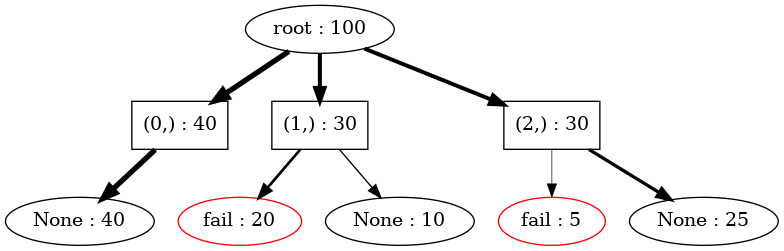

In [ ]:
# Test 1-level tree

constants = {0: {(0,): 0.8, (1,): 0.1, (2,): 0.05}}
tree = Tree(constants)
root = tree.add(name='root', node_type=Variable, count=100, circuit_id=0)
root0 = tree.add(name=(0,), node_type=Constant, parent=root, count=40)
root1 = tree.add(name=(1,), node_type=Constant, parent=root, count=30)
root2 = tree.add(name=(2,), node_type=Constant, parent=root, count=30)
d = tree.add(name='δ', node_type=Delta, parent=root)
none_0 = tree.add(name='None', node_type=Variable, parent=root0, count=40)
none_0.invariant = True
fail_1 = tree.add(name='fail', node_type=Variable, parent=root1, count=20)
none_1 = tree.add(name='None', node_type=Variable, parent=root1, count=10)
fail_2 = tree.add(name='fail', node_type=Variable, parent=root2, count=5)
none_2 = tree.add(name='None', node_type=Variable, parent=root2, count=25)

tree.marked = set([fail_1, fail_2])
tree.deltas.add(d)
tree.draw(verbose=False)

Test numerics of 1-level tree.

In [ ]:
# Test numerics 1-level tree

test_eq(tree.root_leaf_rate, 20/100 + 5/100)
test_eq(tree.subtree_sum(tree.root, tree.marked), 0.1 * 20/30 + 0.05 * 5/30)
test_close(tree.subtree_sum(tree.root, tree.marked | tree.deltas), 1 - (0.8 + 0.1 * 10/30 + 0.05 * 25/30), eps=1e-05)

vL = 0.1**2 * fail_1.var + 0.05**2 * fail_2.var # vL = vL^up
test_close(tree.var(mode=1), vL, eps=1e-05)
test_close(tree.var(mode=0), vL, eps=1e-05)

Test creation of 2-level tree.

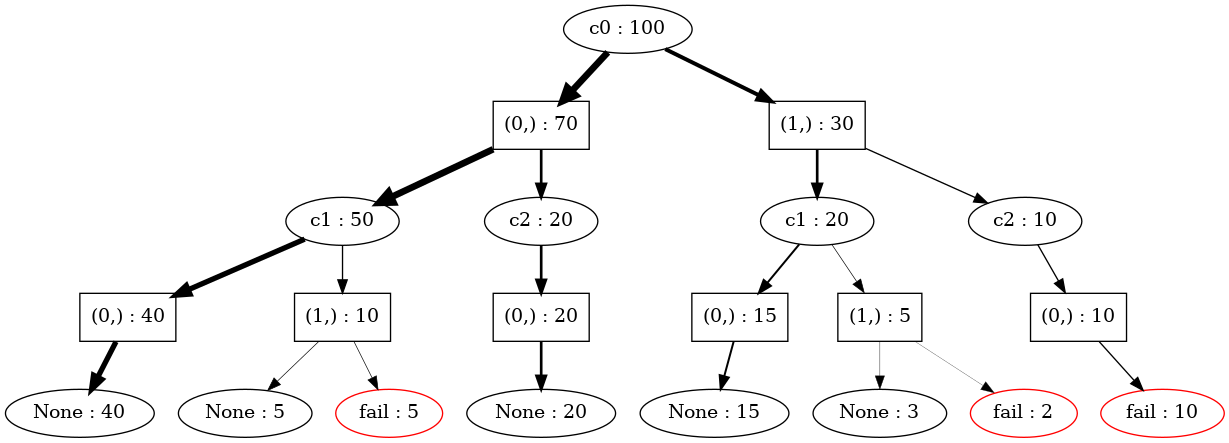

In [ ]:
# Test 2-level tree

constants = {0: {(0,): 0.8, (1,): 0.1}, # c0
             1: {(0,): 0.7, (1,): 0.2}, # c1
             2: {(0,): 1.0}}            # c2

tree = Tree(constants)
root = tree.add(name='c0', circuit_id=0, node_type=Variable, count=100)
root0 = tree.add(name=(0,), node_type=Constant, parent=root, count=70)
root1 = tree.add(name=(1,), node_type=Constant, parent=root, count=30)
d1 = tree.add(name='δ', parent=root, node_type=Delta)

c1_0 = tree.add(name='c1', circuit_id=1, node_type=Variable, count=50, parent=root0)
c1_1 = tree.add(name='c1', circuit_id=1, node_type=Variable, count=20, parent=root1)
c2_0 = tree.add(name='c2', circuit_id=2, node_type=Variable, count=20, parent=root0)
c2_1 = tree.add(name='c2', circuit_id=2, node_type=Variable, count=10, parent=root1)

c1_0_0 = tree.add(name=(0,), node_type=Constant, parent=c1_0, count=40)
c1_0_1 = tree.add(name=(1,), node_type=Constant, parent=c1_0, count=10)
d2 = tree.add(name='δ', node_type=Delta, parent=c1_0)

c1_1_0 = tree.add(name=(0,), node_type=Constant, parent=c1_1, count=15)
c1_1_1 = tree.add(name=(1,), node_type=Constant, parent=c1_1, count=5)
d3 = tree.add(name='δ', node_type=Delta, parent=c1_1)

c2_0_0 = tree.add(name=(0,), node_type=Constant, parent=c2_0, count=20)
d4 = tree.add(name='δ', node_type=Delta, parent=c2_0)
c2_1_0 = tree.add(name=(0,), node_type=Constant, parent=c2_1, count=10)
d5 = tree.add(name='δ', node_type=Delta, parent=c2_1)

none_c1_0_0 = tree.add(name='None', node_type=Variable, parent=c1_0_0, count=40)
none_c1_0_1 = tree.add(name='None', node_type=Variable, parent=c1_0_1, count=5)
fail_c1_0_1 = tree.add(name='fail', node_type=Variable, parent=c1_0_1, count=5)
none_c1_1_0 = tree.add(name='None', node_type=Variable, parent=c1_1_0, count=15)
none_c1_1_1 = tree.add(name='None', node_type=Variable, parent=c1_1_1, count=3)
fail_c1_1_1 = tree.add(name='fail', node_type=Variable, parent=c1_1_1, count=2)

none_c2_0_0 = tree.add(name='None', node_type=Variable, parent=c2_0_0, count=20)
fail_c2_1_0 = tree.add(name='fail', node_type=Variable, parent=c2_1_0, count=10)

tree.marked = set([fail_c1_0_1, fail_c1_1_1, fail_c2_1_0])
tree.deltas = set([d1,d2,d3,d4,d5])
tree.draw()

In [ ]:
A0 = 0.8
A1 = 0.1
B0 = 0.7
B1 = 0.2
C0 = 1

test_close(tree.path_prod(tree.root, fail_c1_0_1), A0*50/70*B1*5/10)
test_close(tree.path_prod(tree.root, fail_c1_1_1), A1*20/30*B1*2/5)
test_close(tree.path_prod(tree.root, fail_c2_1_0), A1*10/30*1)

test_close(tree.path_prod(tree.root, d1), 1 - A0 - A1)
test_close(tree.path_prod(tree.root, d2), A0*50/70*(1-B0-B1))
test_close(tree.path_prod(tree.root, d3), A1*20/30*(1-B0-B1))
test_close(tree.path_prod(tree.root, d4), 0)
test_close(tree.path_prod(tree.root, d5), 0)

In [ ]:
v1 = A0**2 * B1**2 * ((c1_0.var + (50/70)**2)*(fail_c1_0_1.var + (5/10)**2) - (50/70)**2 * (5/10)**2)
test_close(tree.path_var(fail_c1_0_1), v1)

v2 = A0**2 * (1-B0-B1)**2 * c1_0.var
test_close(tree.path_var(d2), v2)

Test numerics of 2-level tree.

In [ ]:
# Test numerics 2-level tree
test_eq(tree.root_leaf_rate, 5/100 + 2/100 + 10/100)

pL = A0 * 50/70 * 0.2 * 5/10 + A1 * (20/30 * B1 * 2/5 + 10/30 * C0 * 1)
pL_up = 1 - A0 - A1 + A0*(50/70)*(1-B0-B1*5/10) + A1*(20/30)*(1-B0-B1*(3/5)) + A1*10/30*C0*1

test_eq(tree.subtree_sum(tree.root, tree.marked), pL)
test_close(tree.subtree_sum(tree.root, tree.marked | tree.deltas), pL_up, eps=1e-05)

v14 = (c1_0.var + (50/70)**2)*(fail_c1_0_1.var + (5/10)**2) - (50/70)**2 * (5/10)**2
v27 = (c1_1.var + (20/30)**2)*(fail_c1_1_1.var + (2/5)**2) - (20/30)**2 * (2/5)**2
v2bar8 = (c2_1.var + (10/30)**2) * (fail_c2_1_0.var + (1)**2) - (10/30)**2 * (1)**2
vL = A0**2*B1**2*v14 + A1**2*B1**2*v27 + A1**2*C0**2*v2bar8 - 2*A1*A1*B1*C0*(2/5)*(1)*c1_1.var

test_close(tree.var(mode=1), vL)

delta = 1 - B0 - B1
v1 = c1_0.var
v2 = c1_1.var
q4 = fail_c1_0_1.rate
q7 = fail_c1_1_1.rate
q8 = fail_c2_1_0.rate

vL_up = (A0**2 * delta**2 * v1 + 
         A0**2 * B1**2 * v14 +
         A1**2 * delta**2 * v2 + 
         A1**2 * B1**2 * v27 +
         A1**2 * C0**2 * v2bar8 +
         2 * (A0**2 * delta * B1 * q4 * v1 +
              A1**2 * delta * B1 * q7 * v2 -
              A1**2 * C0 * delta * v2 -
              A1**2 * B1 * C0 * q7 * q8 * v2
             )
        )

test_close(tree.var(mode=0), vL_up)

In [ ]:
tree.path_var(c1_1), tree.path_var(c2_1), c1_1.count, c2_1.count, c2_1.parent.count, c1_1.parent.count

A1**2 * ((c2_1.var + c2_1.rate**2) - c2_1.rate**2), A1**2 * ((c1_1.var + c1_1.rate**2) - c1_1.rate**2), tree.path_var(c1_1), tree.path_var(c2_1)

# Note tiny numeric inaccuracies in resumming: c2_1.rate**2 - c2_1.rate**2 = 0, but here not.

A1**2 * ((0.001 + c2_1.rate**2) - c2_1.rate**2), A1**2 * 0.001
# not exactly equal!

(1.0000000000000011e-05, 1.0000000000000003e-05)